In [25]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
import seaborn as sns
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import os.path
import random
import cv2


In [26]:
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# from google.colab import drive
# drive.mount('/content/gdrive/');

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cuda


**Visualize images from Dataset:**

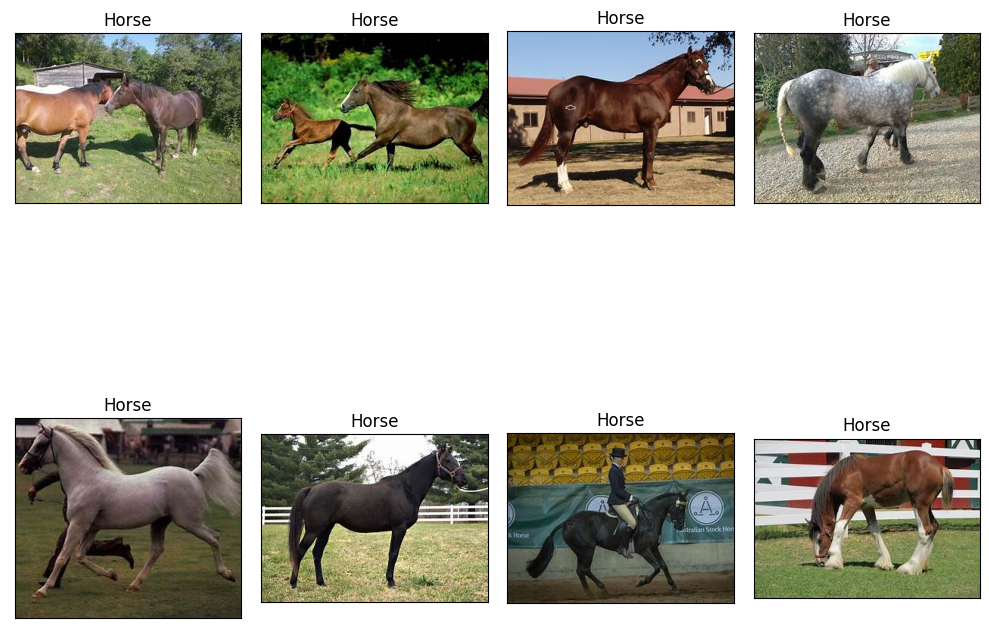

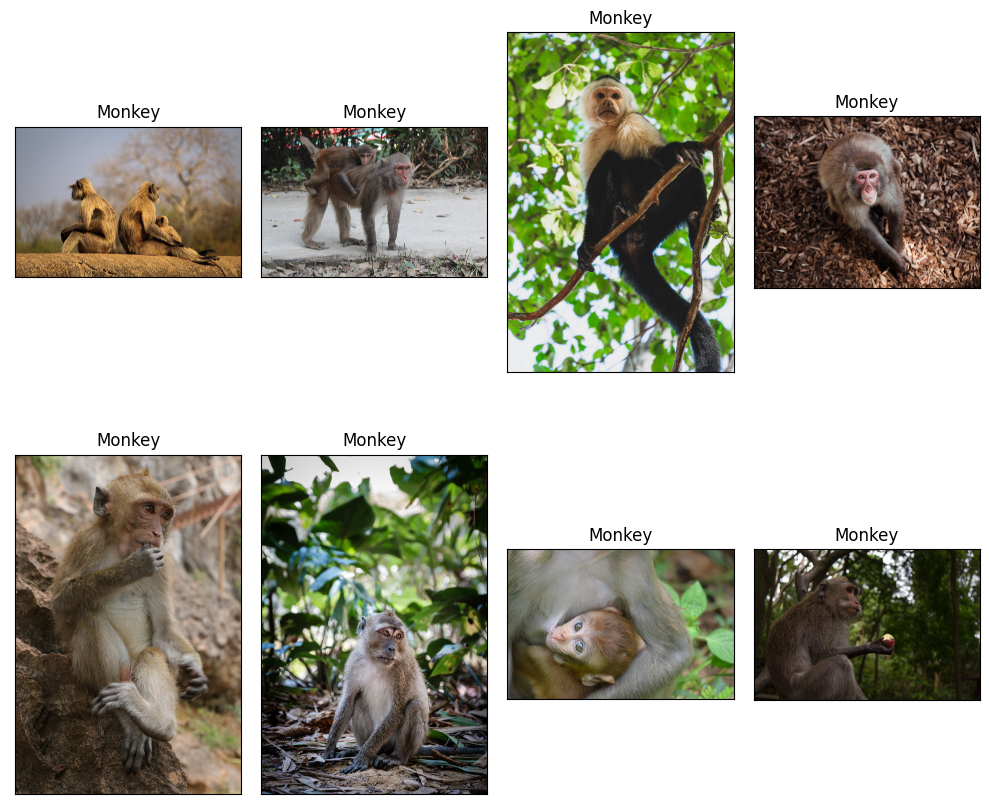

In [27]:
dataset = "Final_Dataset/dataset3/train/horse"
list = []
for image in os.listdir(dataset):
  list.append(os.path.join(dataset,image))
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(list[i]))
    ax.set_title("Horse")

plt.tight_layout()
plt.show()

dataset = "Final_Dataset/dataset3/train/monkey"
list = []
for image in os.listdir(dataset):
  list.append(os.path.join(dataset,image))
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(list[i]))
    ax.set_title("Monkey")

plt.tight_layout()
plt.show()

In [28]:
def load_Data():
    train_dataset = datasets.ImageFolder("Final_Dataset/dataset3/train", transform=transform)
    val_dataset = datasets.ImageFolder("Final_Dataset/dataset3/val", transform=test_transform)
    test_dataset = datasets.ImageFolder("Final_Dataset/dataset3/test", transform=test_transform)

    print(train_dataset.class_to_idx)
    #print(test_dataset.class_to_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader,val_loader,test_loader
load_Data()

{'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}


(<torch.utils.data.dataloader.DataLoader at 0x7ff4924dba00>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff4920b7250>)

In [29]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
class Model(nn.Module):
  def __init__(self,input) -> None:
      super(Model,self).__init__()
      self.model = torchvision.models.mobilenet_v2(pretrained=False)
      #self.num_ftrs = self.model.classifier[1].in_features
      #print(num_ftrs)
      self.fc_layer = nn.Sequential(
      nn.Linear(1280,640),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      
      nn.Linear(640,320),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      
      nn.Linear(320,160),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(160, 12)
    )
      
      self.model.classifier = self.fc_layer
      self.features = {}
      self.model.classifier.register_forward_pre_hook(self.get_features("embeddings"))
      
  def get_features(self,name):
      def hook(model, input):
          self.features[name] = input[0].detach().cpu().numpy()
      return hook
  def forward(self, x):
        x = self.model(x)
        return x
model = Model((224,224))
print(model)

Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), st

In [31]:
# Save checkpoint 
def save_checkpoint(state, filename):
    torch.save(state, filename)


In [32]:
# datastructure to store all the training testing and validation results.
y_train = []
y_expected_train = []
y_val = []
y_expected_val = []
y_test = []
y_expected_test = []
trainloss = []
valloss =[]
epochnum = []  

In [33]:
print(torch.cuda.is_available())
def train(model, train_loader, criterion, optimizer, epoch, step=5):
    
    model.train()
    loss_list = AverageMeter()
    for i, (images, labels) in enumerate(train_loader):
        #print(torch.cuda.is_available())
        total =0
        correct = 0
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        #print(predicted,type(predicted))
        #print(labels,type(labels))
        output = model(images)
        loss = criterion(output,labels)
        loss_list.update(loss.data, images.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        y_train.extend(predicted.to(torch.device('cpu')))
        y_expected_train.extend(labels.to(torch.device('cpu')))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        #print( f'Training Accuracy: {accuracy:.2f}%')
            
        if i%step==0:
            print('EPOCH {} | ITER {} | AVG_LOSS {} | Train_ACC {}'.format(epoch, i, loss_list.avg,accuracy))
        writer.add_scalar('TRAIN_LOSS', loss, epoch)
        
    return loss,accuracy

True


In [34]:
def val(model, val_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    loss_list = AverageMeter()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            #print("Inside validation");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            loss = criterion(outputs,labels)
            loss_list.update(loss.data, inputs.size(0))
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print("CORRECT",correct)
            #print("Total",total)
        accuracy = 100 * correct / total
        print(f'Val Accuracy: {accuracy:.2f}%')
        return loss,accuracy
    

In [35]:
def test(model, test_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        print("*"*40)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            #print("Inside test");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_test.extend(predicted.to(torch.device('cpu')))
            y_expected_test.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'test Accuracy: {accuracy:.2f}%')
        return accuracy
    

In [36]:
def visualize(model , data_loader):
    class2idx = {'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}
    idx2class = { value : key for key,value in  class2idx.items() }
    embeddings = np.array([])
    labels = np.array([])
    model.eval()
    out_features = 1280
    num_categories = 12
    with torch.no_grad(): 
        for i,data in enumerate(data_loader):
            images, labs = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            embeds = model.features["embeddings"].reshape(-1, 1280)
            embeddings = np.append(embeddings , embeds)
            labels = np.append(labels,labs.cpu())
  
    embeddings = embeddings.reshape(-1, 1280)
    
    c_labels = labels.reshape(-1 , 1).ravel()
    tsne = TSNE(n_components=2,perplexity=2).fit_transform(embeddings)
    labels = np.array([ idx2class[ele] for ele in c_labels])
    
    cmap = cm.get_cmap('tab20')
    
    for lab in range(num_categories):
        indices = (c_labels == lab)
        plt.scatter(tsne[indices, 0],tsne[indices, 1],c=np.array(cmap(lab)).reshape(1, 4),label=lab,alpha=1)
        plt.legend(fontsize='large', markerscale=2)
    plt.show()
  
# model = Model((224,224))
# train_loader, val_loader ,test_loader = load_Data()
# visualize(model,test_loader)



In [37]:
def plotloss():
  plt.figure(figsize=(20,10))
  plt.plot(epochnum, trainloss)
  plt.plot(epochnum, valloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [38]:
class2idx = {'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))
 
    plt.suptitle("Confusion Matrix")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



True
using gpu
{'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}
EPOCH 0 | ITER 0 | AVG_LOSS 2.492961883544922 | Train_ACC 3.125
EPOCH 0 | ITER 5 | AVG_LOSS 2.4810328483581543 | Train_ACC 15.625
EPOCH 0 | ITER 10 | AVG_LOSS 2.4896819591522217 | Train_ACC 12.5
EPOCH 0 | ITER 15 | AVG_LOSS 2.4735360145568848 | Train_ACC 9.375
EPOCH 0 | ITER 20 | AVG_LOSS 2.4763052463531494 | Train_ACC 12.5
EPOCH 0 | ITER 25 | AVG_LOSS 2.4610726833343506 | Train_ACC 28.125
EPOCH 0 | ITER 30 | AVG_LOSS 2.4657676219940186 | Train_ACC 15.625
EPOCH 0 | ITER 35 | AVG_LOSS 2.460088014602661 | Train_ACC 12.5
EPOCH 0 | ITER 40 | AVG_LOSS 2.448462963104248 | Train_ACC 18.75
EPOCH 0 | ITER 45 | AVG_LOSS 2.43822979927063 | Train_ACC 6.25
EPOCH 0 | ITER 50 | AVG_LOSS 2.4321389198303223 | Train_ACC 9.375
EPOCH 0 | ITER 55 | AVG_LOSS 2.4343693256378174 | Train_ACC 9.375
EPOCH 0 | ITER 60 | AVG_LOSS 2.4290006160736084 

Bad pipe message: %s [b':\xc7\x85\x99\x86\x02\t\x15\x84\tx31\x00']
Bad pipe message: %s [b'\x13k bJ2\xce\x7f\x06L\x9b\x17\x1b\xb0\xdd\\\xd0Ca\xc5.', b'\xd9QZ\xd5\x93\x0cV\xc9\xc8\x1f+5\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00']
Bad pipe message: %s [b'\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07']
Bad pipe message: %s [b'\x08\t\x08\n\x08\x0b\x08']
Bad pipe message: %s [b'\x05\x08\x06']
Bad pipe message: %s [b"3B\x05G\xa5X\xff\x1c\x1e\xbe\x9b$\xae\xb9\x8d\x8e\xccl VM\xa8\x07u\xbb\xbc>\x8d\x86v\x8b<i\x9f\x1d\x8d')\xd1\\u\xb0:\x95T\xb0\xe3!h\x10J\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02"]
Bad pipe message: %s [b'\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$

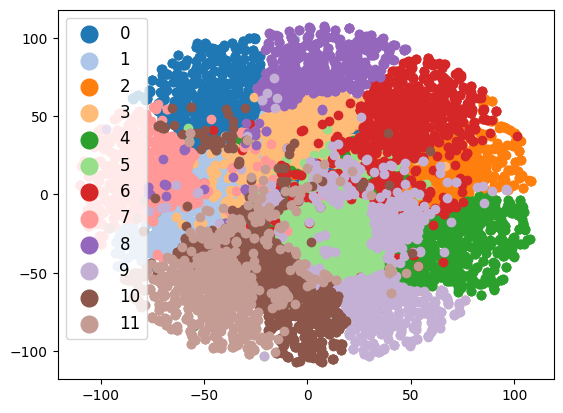

In [39]:
def main():
    model = Model((224,224));
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        model = model.cuda()
        print("using gpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 30

    train_loader, val_loader ,test_loader = load_Data()
 
    history = open("Results/dataset3_Mobilenet_history.csv",'w')
    history.write('epochs , trainloss , Train-acc,val_acc , test_acc \n')
    max_accuracy = 0 
    for epoch in range(0,epochs):
        start = time.time()
        train_loss,accuracy = train(model, train_loader, criterion, optimizer, epoch)
        vallosss,val_loss = val(model, val_loader, criterion, optimizer, epoch)
        test_loss = test(model, test_loader, criterion, optimizer, epoch)
        trainloss.append(train_loss.cpu().detach().numpy())
        valloss.append(vallosss.cpu().detach().numpy())
        epochnum.append(epoch)
        print()
        print('-' * 50)
        print('EPOCH {} | LOSS {} | TIME {}'.format(epoch, train_loss, time.time() - start))
        print('-' * 50)
        print()

        if(val_loss > max_accuracy):
          max_accuracy = val_loss
          save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),'loss' : train_loss}, "Checkpoints/dataset3_Mobilenetv2_checkpoint.ckpt")

        history.write('{},{},{},{},{}\n'.format(epoch, train_loss,accuracy, val_loss , test_loss))
        
    history.close()
    visualize(model,train_loader)
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()

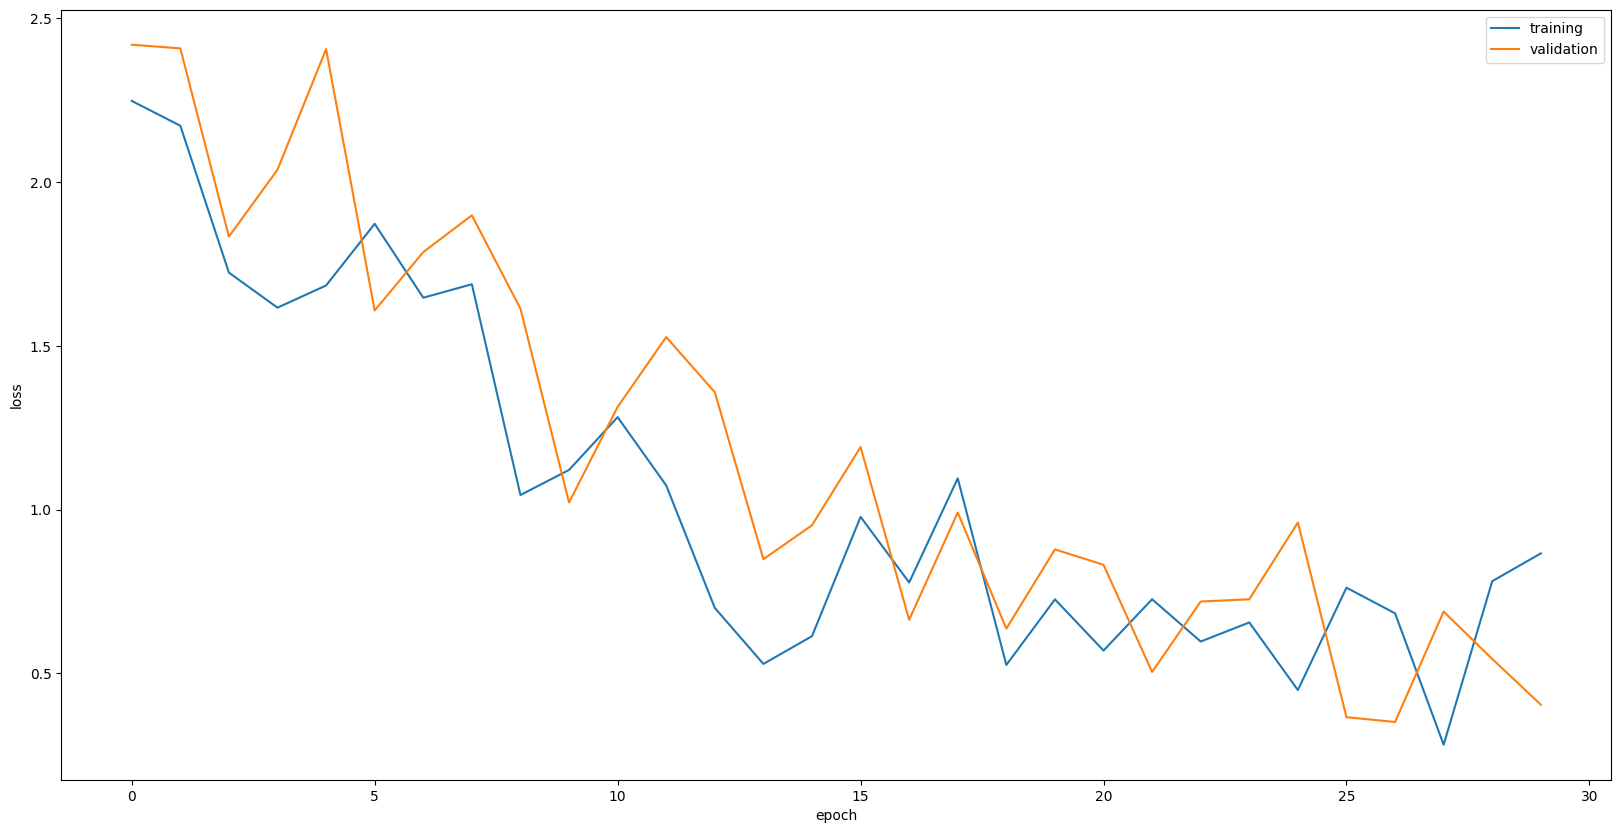

In [40]:
plotloss()

['butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly'

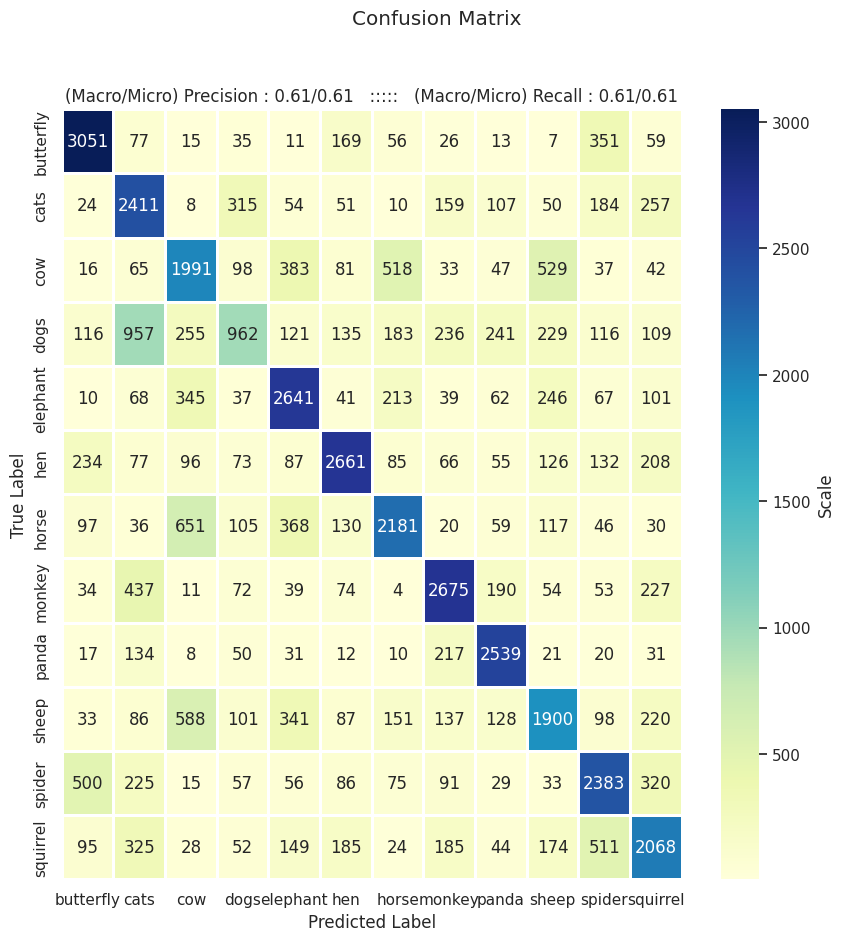

In [41]:

class2idx = {'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}

idx2class = { value : key  for key , value in class2idx.items() }
y_true = [idx2class[val.item()] for val in y_expected_test ]
y_pred = [idx2class[val.item()] for val in y_test ]
print(y_true)
print(y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")
f1_score = (2*micro_precision*micro_recall)/(micro_recall + micro_precision)
print("f1 - Score is :--- " ,f1_score)
cnf_matrix = confusion_matrix(y_true , y_pred , labels=['butterfly','cats','cow','dogs','elephant','hen','horse','monkey','panda','sheep', 'spider', 'squirrel'])
plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall], output_filename = "cnf_mobilenet_Data3.png")